#Policy Gradient Algorithm, using a neural network

##Introduction

We use the environment that we have written and can be found here: https://github.com/derdav3/Drop7Gym.git

We used for training the code found on https://github.com/JannesKlaas/sometimes_deep_sometimes_learning/blob/master/reinforcement.ipynb and we adapted the parts we had to.

This notebook was run on Google Colab.

This notebook should be run in the order it is built, as we changed some methods between the different trainings.
Some methods are duplicated as we wanted to try new things and didn't want to risk to loose the results of the already ran models.

In [1]:
# !git clone https://github.com/derdav3/Drop7Gym.git
import sys 
sys.path.append('..') #hack to import module from parent folder


In [2]:
!pip install tensorflow

In [3]:
import sys
sys.path.append("Drop7Gym")
import tensorflow as tf

2024-07-16 10:51:05.999814: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-16 10:51:06.000358: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-16 10:51:06.003100: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-16 10:51:06.010277: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 10:51:06.021705: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [4]:
#Keras is a deep learning libarary
from keras.models import model_from_json
from keras.models import Sequential
from tensorflow.keras.layers import Dense
import keras.optimizers

In [5]:
import numpy as np
import gym
import gym_drop7
import cfg
import matplotlib.pyplot as plt
import datetime

In [6]:
class ExperienceReplay(object):
    """
    During gameplay all the experiences < s, a, r, s’ > are stored in a replay memory. 
    In training, batches of randomly drawn experiences are used to generate the input and target for training.
    """
    def __init__(self, max_memory=100, discount=.9):
        """
        Setup
        max_memory: the maximum number of experiences we want to store
        memory: a list of experiences
        discount: the discount factor for future experience
        
        In the memory the information whether the game ended at the state is stored seperately in a nested array
        [...
        [experience, game_over]
        [experience, game_over]
        ...]
        """
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, game_over):
        #Save a state to memory
        self.memory.append([states, game_over])
        #We don't want to store infinite memories, so if we have too many, we just delete the oldest one
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        
        #How many experiences do we have?
        len_memory = len(self.memory)
        
        #Calculate the number of actions that can possibly be taken in the game
        num_actions = model.output_shape[-1]
        
        #Dimensions of the game field
        env_dim = self.memory[0][0][0].shape[1]
                
        #We want to return an input and target vector with inputs from an observed state...
        inputs = np.zeros((min(len_memory, batch_size), env_dim))
                
        #...and the target r + gamma * max Q(s’,a’)
        #Note that our target is a matrix, with possible fields not only for the action taken but also
        #for the other possible actions. The actions not take the same value as the prediction to not affect them
        targets = np.zeros((inputs.shape[0], num_actions))
        
        #We draw states to learn from randomly
        for i, idx in enumerate(np.random.randint(0, len_memory,
                                                  size=inputs.shape[0])):
            """
            Here we load one transition <s, a, r, s’> from memory
            state_t: initial state s
            action_t: action taken a
            reward_t: reward earned r
            state_tp1: the state that followed s’
            """
            state_t, action_t, reward_t, state_tp1 = self.memory[idx][0]
            
            #print('state_t',state_t)
            
            #We also need to know whether the game ended at this state
            game_over = self.memory[idx][1]

            #add the state s to the input
            inputs[i:i+1] = state_t
            
            # First we fill the target values with the predictions of the model.
            # They will not be affected by training (since the training loss for them is 0)
            targets[i] = model.predict(state_t)[0]
            
            """
            If the game ended, the expected reward Q(s,a) should be the final reward r.
            Otherwise the target value is r + gamma * max Q(s’,a’)
            """
            #  Here Q_sa is max_a'Q(s', a')
            Q_sa = np.max(model.predict(state_tp1)[0])
            
            #if the game ended, the reward is the final reward
            if game_over:  # if game_over is True
                targets[i, action_t] = reward_t
            else:
                # r + gamma * max Q(s’,a’)
                targets[i, action_t] = reward_t + self.discount * Q_sa
        return inputs, targets

In [7]:
def baseline_model(grid_size,num_actions,hidden_size):
    #seting up the model with keras
    model = Sequential()
    model.add(Dense(hidden_size, input_shape=((grid_size**2) + 1,), activation='relu'))
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss="mse")
    return model

In [8]:
def prepare_input(tuple):
  number_to_insert = tuple[0]
  field = tuple[1]
  inputmatrix = field.reshape(1, -1)
  inputmatrix = np.append(inputmatrix, [[number_to_insert]], axis = 1)
  return inputmatrix

## Default model

This is the default model we trained. Compared to the original code, we implemented a decreasing epsilon rate, that determines random actions, so that the model can learn new connections.

In [9]:
def train(model,epochs, verbose = 1):
    # Train
    #Reseting the win counter
    # We want to keep track of the progress of the AI over time, so we save its win count history
    win_hist = []
    loss_hist = []
    
    #Epochs is the number of games we play
    for e in range(epochs):
        #decreasing epsilon rate
        progress = e / epochs
        epsilon_diff = max_epsilon - min_epsilon
        epsilon = max_epsilon - (epsilon_diff * progress)
        loss = 0.
        win_cnt = 0
        #Resetting the game
        raw_input = env.reset()
        game_over = False
        # get initial input
        input_t = prepare_input(raw_input)
        
        while not game_over:
            #The learner is acting on the last observed game screen
            #input_t is a vector containing representing the game screen
            input_tm1 = input_t
            
            """
            We want to avoid that the learner settles on a local minimum.
            Imagine you are eating eating in an exotic restaurant. After some experimentation you find 
            that Penang Curry with fried Tempeh tastes well. From this day on, you are settled, and the only Asian 
            food you are eating is Penang Curry. How can your friends convince you that there is better Asian food?
            It's simple: Sometimes, they just don't let you choose but order something random from the menu.
            Maybe you'll like it.
            The chance that your friends order for you is epsilon
            """
            if np.random.rand() <= epsilon:
                #Eat something random from the menu
                action = np.random.randint(0, num_actions)
            else:
                #Choose yourself
                #q contains the expected rewards for the actions
                q = model.predict(input_tm1)
                #We pick the action with the highest expected reward
                action = np.argmax(q[0])

            # apply action, get rewards and new state
            raw_input, reward, game_over, something = env.step(action)
            input_t = prepare_input(raw_input)
            #sum the reward
            win_cnt += reward        
            
            """
            The experiences < s, a, r, s’ > we make during gameplay are our training data.
            Here we first save the last experience, and then load a batch of experiences to train our model
            """
            
            # store experience
            exp_replay.remember([input_tm1, action, reward, input_t], game_over) 
            
            # Load batch of experiences
            inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)
  
            # train model on experiences
            batch_loss = model.train_on_batch(inputs, targets)
            
            #print(loss)
            loss += batch_loss
        if (verbose > 0 and e % 50 == 0):
            print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win count {}".format(e,epochs, loss, win_cnt))
            print(datetime.datetime.now())
        win_hist.append(win_cnt)
        loss_hist.append(loss)
    return win_hist, loss_hist

In [10]:
# parameters
max_epsilon = .4  # exploration
min_epsilon = 0.05
num_actions = 7  # [0, 1, 2, 3, 4, 5, 6]
max_memory = 500 # Maximum number of experiences we are storing
hidden_size = 100 # Size of the hidden layers
batch_size = 1 # Number of experiences we use for training per batch
grid_size = 7 # Size of the playing field


In [11]:
#Define model
model = baseline_model(grid_size,num_actions,hidden_size)
model.summary()

/home/j-vangoey/.pyenv/versions/3.11.9/envs/drop7/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1721119867.897805 1135636 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-16 10:51:07.898179: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required l

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           707 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,907 (62.14 KB)

 Trainable params: 15,907 (62.14 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Define environment/game
env = gym.make('Drop7-v1')

# Initialize experience replay object
exp_replay = ExperienceReplay(max_memory=max_memory)

/home/j-vangoey/.pyenv/versions/3.11.9/envs/drop7/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (7, 7)
  logger.warn(


In [13]:
epoch = 5000
# Train the model
# For simplicity of the noteb
hist, loss = train(model, epoch, verbose=1)
print("Training done")

/home/j-vangoey/.pyenv/versions/3.11.9/envs/drop7/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/j-vangoey/.pyenv/versions/3.11.9/envs/drop7/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/home/j-vangoey/.pyenv/versions/3.11.9/envs/drop7/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:149: UserWarning: WARN: The obs returned by the `reset()` method was expecting a tuple, actual type: <class 'int'>
  logger.warn(f"{pre} was expecting a tuple, actual type: {type(obs)}")


TypeError: object of type 'int' has no len()

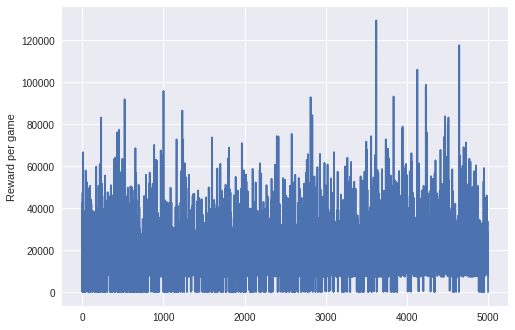

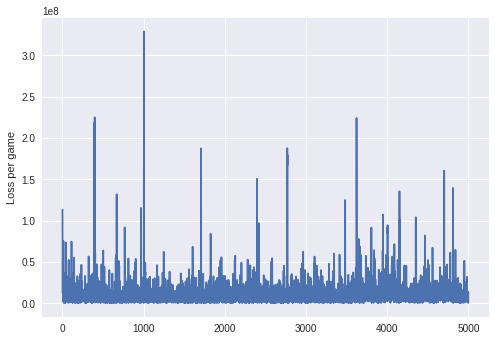

In [ ]:

plt.plot(hist)
plt.ylabel('Reward per game')
plt.show()

plt.plot(loss)
plt.ylabel('Loss per game')
plt.show()

### Results
The result is quite disappointing. There is no convergence to see in the loss and the reward of the game.

## Normalized model

We saw that there is no convergence of the preceding model. So we asked ourself if the input is not correct. In this model we work with normalized and positive inputs. 



In [ ]:
def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

In [ ]:
def prepare_input(tuple):
  number_to_insert = tuple[0]
  field = tuple[1]
  inputmatrix = field.reshape(1, -1)
  inputmatrix = np.append(inputmatrix, [[number_to_insert]], axis = 1)
  # no negativ values, as we have in the original input numbers from -2 to 7
  inputmatrix = inputmatrix + 2
  inputmatrix = normalized(inputmatrix)
  return inputmatrix


In [ ]:
# parameters
max_epsilon = .4  # exploration
min_epsilon = 0.05
num_actions = 7  # [0, 1, 2, 3, 4, 5, 6]
max_memory = 500 # Maximum number of experiences we are storing
hidden_size = 100 # Size of the hidden layers
batch_size = 1 # Number of experiences we use for training per batch
grid_size = 7 # Size of the playing field


In [ ]:
def train(model,epochs, verbose = 1):
    # Train
    #Reseting the win counter
    # We want to keep track of the progress of the AI over time, so we save its win count history
    win_hist = []
    loss_hist = []
    
    #Epochs is the number of games we play
    for e in range(epochs):
        #decreasing epsilon rate
        progress = e / epochs
        epsilon_diff = max_epsilon - min_epsilon
        epsilon = max_epsilon - (epsilon_diff * progress)
        loss = 0.
        win_cnt = 0
        #Resetting the game
        raw_input = env.reset()
        game_over = False
        # get initial input
        input_t = prepare_input(raw_input)
        
        while not game_over:
            #The learner is acting on the last observed game screen
            #input_t is a vector containing representing the game screen
            input_tm1 = input_t
            
            """
            We want to avoid that the learner settles on a local minimum.
            Imagine you are eating eating in an exotic restaurant. After some experimentation you find 
            that Penang Curry with fried Tempeh tastes well. From this day on, you are settled, and the only Asian 
            food you are eating is Penang Curry. How can your friends convince you that there is better Asian food?
            It's simple: Sometimes, they just don't let you choose but order something random from the menu.
            Maybe you'll like it.
            The chance that your friends order for you is epsilon
            """
            if np.random.rand() <= epsilon:
                #Eat something random from the menu
                action = np.random.randint(0, num_actions)
            else:
                #Choose yourself
                #q contains the expected rewards for the actions
                q = model.predict(input_tm1)
                #We pick the action with the highest expected reward
                action = np.argmax(q[0])

            # apply action, get rewards and new state
            raw_input, reward, game_over, something = env.step(action)
            input_t = prepare_input(raw_input)
            #sum the reward
            win_cnt += reward        
            
            
            """
            The experiences < s, a, r, s’ > we make during gameplay are our training data.
            Here we first save the last experience, and then load a batch of experiences to train our model
            """
            
            # store experience
            exp_replay.remember([input_tm1, action, reward, input_t], game_over) 
            
            # Load batch of experiences
            inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)
  
            # train model on experiences
            batch_loss = model.train_on_batch(inputs, targets)
            
            loss += batch_loss
        if (verbose > 0 and e % 50 == 0):
            print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win count {}".format(e,epochs, loss, win_cnt))
            print(datetime.datetime.now())
        win_hist.append(win_cnt)
        loss_hist.append(loss)
    return win_hist, loss_hist

For each model we have to reinitialize a new env, experience_replay and model.

In [ ]:
# Define environment/game
env = gym.make('Drop7-v1')

# Initialize experience replay object
exp_replay = ExperienceReplay(max_memory=max_memory)

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [ ]:
#Define model
model = baseline_model(grid_size,num_actions,hidden_size)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_26 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_27 (Dense)             (None, 7)                 707       
Total params: 15,907
Trainable params: 15,907
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epoch = 2000 
# Train the model
# For simplicity of the noteb
hist0_5, loss0_5 = train(model, epoch, verbose=1)
print("Training done")

Epoch 000/2000 | Loss 31324455.4394 | Win count 50347.0
2018-12-30 14:46:49.240870
Epoch 050/2000 | Loss 8737642.7642 | Win count 18778.0
2018-12-30 14:47:27.007793
Epoch 100/2000 | Loss 12938981.6614 | Win count 155.0
2018-12-30 14:48:06.131906
Epoch 150/2000 | Loss 25951331.5783 | Win count 37962.0
2018-12-30 14:48:40.831589
Epoch 200/2000 | Loss 9001080.9443 | Win count 15066.0
2018-12-30 14:49:19.534386
Epoch 250/2000 | Loss 11519399.9130 | Win count 25932.0
2018-12-30 14:49:56.573521
Epoch 300/2000 | Loss 7035303.7947 | Win count 8427.0
2018-12-30 14:50:32.096361
Epoch 350/2000 | Loss 4072880.1045 | Win count 70.0
2018-12-30 14:51:08.105214
Epoch 400/2000 | Loss 3919302.7625 | Win count 7544.0
2018-12-30 14:51:46.793391
Epoch 450/2000 | Loss 7731599.5570 | Win count 15416.0
2018-12-30 14:52:24.213443
Epoch 500/2000 | Loss 10139269.6559 | Win count 20184.0
2018-12-30 14:52:56.760046
Epoch 550/2000 | Loss 3848628.0518 | Win count 8075.0
2018-12-30 14:53:28.921150
Epoch 600/2000 | Lo

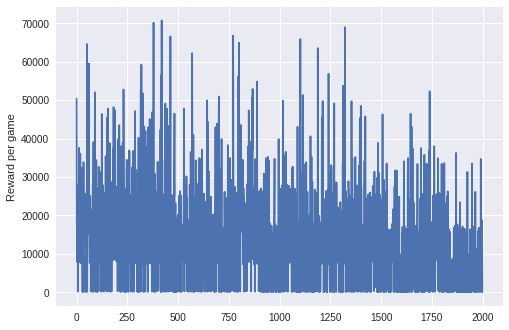

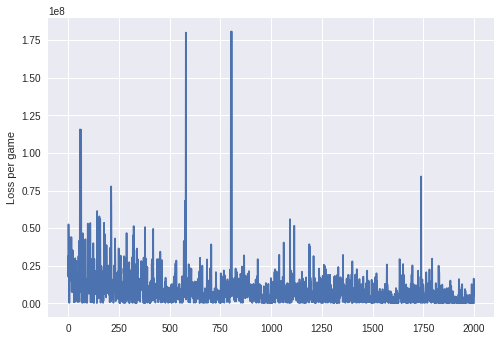

In [ ]:
plt.plot(hist0_5)
plt.ylabel('Reward per game')
plt.show()

plt.plot(loss0_5)
plt.ylabel('Loss per game')
plt.show()

### Results
We were surprise about the results. After we introduced normalization, the results are converging. However the rewards are converging wrong, the decrease with decreasing loss.

## Failed try to fix the normalized model; Batch Size 10

As we saw in the preceding model, that it converges wrongly, we tried different things, to fix that. 
We tested the ExperienceReplay class, if there is stored something wrongly, checked the input and targets for the model, changed the (arg-)maxs to (arg-)mins and back, tested the normalization methods and so on. 
All the tests were quite time consuming, as the model hade to trained again. Sadly, we were no able to find the error.
So we tested the influence of increasing the batch size to ten.

In [ ]:
class ExperienceReplay(object):
    """
    During gameplay all the experiences < s, a, r, s’ > are stored in a replay memory. 
    In training, batches of randomly drawn experiences are used to generate the input and target for training.
    """
    def __init__(self, max_memory=100, discount=.9):
        """
        Setup
        max_memory: the maximum number of experiences we want to store
        memory: a list of experiences
        discount: the discount factor for future experience
        
        In the memory the information whether the game ended at the state is stored seperately in a nested array
        [...
        [experience, game_over]
        [experience, game_over]
        ...]
        """
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, game_over):
        #Save a state to memory
        self.memory.append([states, game_over])
        #We don't want to store infinite memories, so if we have too many, we just delete the oldest one
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        
        #How many experiences do we have?
        len_memory = len(self.memory)
        
        #Calculate the number of actions that can possibly be taken in the game
        num_actions = model.output_shape[-1]
        
        #Dimensions of the game field
        env_dim = self.memory[0][0][0].shape[1]
        
        #We want to return an input and target vector with inputs from an observed state...
        inputs = np.zeros((min(len_memory, batch_size), env_dim))
        
        #...and the target r + gamma * max Q(s’,a’)
        #Note that our target is a matrix, with possible fields not only for the action taken but also
        #for the other possible actions. The actions not take the same value as the prediction to not affect them
        targets = np.zeros((inputs.shape[0], num_actions))
        
        #We draw states to learn from randomly
        for i, idx in enumerate(np.random.randint(0, len_memory,
                                                  size=inputs.shape[0])):
            """
            Here we load one transition <s, a, r, s’> from memory
            state_t: initial state s
            action_t: action taken a
            reward_t: reward earned r
            state_tp1: the state that followed s’
            """
            state_t, action_t, reward_t, state_tp1 = self.memory[idx][0]
            
            #We also need to know whether the game ended at this state
            game_over = self.memory[idx][1]

            #add the state s to the input
            inputs[i:i+1] = state_t
            
            # First we fill the target values with the predictions of the model.
            # They will not be affected by training (since the training loss for them is 0)
            targets[i] = model.predict(state_t)[0]
            
            """
            If the game ended, the expected reward Q(s,a) should be the final reward r.
            Otherwise the target value is r + gamma * max Q(s’,a’)
            """
            #  Here Q_sa is max_a'Q(s', a')
            Q_sa = np.max(model.predict(state_tp1)[0])
            
            #if the game ended, the reward is the final reward
            #changed the reward in contrast to the preceding models, trying to fix the model
            if game_over:  # if game_over is True
                targets[i, action_t] = reward_t
            else:
                targets[i, action_t] = reward_t
        return inputs, targets

In [ ]:
def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

In [ ]:
def prepare_input(tuple):
  number_to_insert = tuple[0]
  field = tuple[1]
  inputmatrix = field.reshape(1, -1)
  inputmatrix = np.append(inputmatrix, [[number_to_insert]], axis = 1)
  # no negativ values
  inputmatrix = inputmatrix + 2
  inputmatrix = normalized(inputmatrix)
  return inputmatrix


In [ ]:
# parameters
max_epsilon = .4  # exploration
min_epsilon = 0.05
num_actions = 7  # [0, 1, 2, 3, 4, 5, 6]
max_memory = 500 # Maximum number of experiences we are storing
hidden_size = 100 # Size of the hidden layers
batch_size = 10 # Number of experiences we use for training per batch
grid_size = 7 # Size of the playing field


In [ ]:
def train(model,epochs, verbose = 1):
    # Train
    #Reseting the win counter
    # We want to keep track of the progress of the AI over time, so we save its win count history
    win_hist = []
    loss_hist = []
    
    #Epochs is the number of games we play
    for e in range(epochs):
        #decreasing epsilon rate
        progress = e / epochs
        epsilon_diff = max_epsilon - min_epsilon
        epsilon = max_epsilon - (epsilon_diff * progress)
        loss = 0.
        win_cnt = 0
        #Resetting the game
        raw_input = env.reset()
        game_over = False
        # get initial input
        input_t = prepare_input(raw_input)
        
        while not game_over:
            #The learner is acting on the last observed game screen
            #input_t is a vector containing representing the game screen
            input_tm1 = input_t
            
            """
            We want to avoid that the learner settles on a local minimum.
            Imagine you are eating eating in an exotic restaurant. After some experimentation you find 
            that Penang Curry with fried Tempeh tastes well. From this day on, you are settled, and the only Asian 
            food you are eating is Penang Curry. How can your friends convince you that there is better Asian food?
            It's simple: Sometimes, they just don't let you choose but order something random from the menu.
            Maybe you'll like it.
            The chance that your friends order for you is epsilon
            """
            if np.random.rand() <= epsilon:
                #Eat something random from the menu
                action = np.random.randint(0, num_actions)
            else:
                #Choose yourself
                #q contains the expected rewards for the actions
                q = model.predict(input_tm1)
                #We pick the action with the highest expected reward
                action = np.argmax(q[0])

            # apply action, get rewards and new state
            raw_input, reward, game_over, something = env.step(action)
            input_t = prepare_input(raw_input)
            #sum the reward
            win_cnt += reward        
            
            """
            The experiences < s, a, r, s’ > we make during gameplay are our training data.
            Here we first save the last experience, and then load a batch of experiences to train our model
            """
            
            # store experience
            exp_replay.remember([input_tm1, action, reward, input_t], game_over) 
            
            # Load batch of experiences
            inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)
  
            # train model on experiences
            batch_loss = model.train_on_batch(inputs, targets)
            
            loss += batch_loss
        #if (verbose > 0 and e % 50 == 0):
        if (verbose > 0):
            print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win count {}".format(e,epochs, loss, win_cnt))
            print(datetime.datetime.now())
        win_hist.append(win_cnt)
        loss_hist.append(loss)
    return win_hist, loss_hist

In [ ]:
# Define environment/game
env = gym.make('Drop7-v1')

# Initialize experience replay object
exp_replay = ExperienceReplay(max_memory=max_memory)

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [ ]:
#Define model
model = baseline_model(grid_size,num_actions,hidden_size)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_65 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_66 (Dense)             (None, 7)                 707       
Total params: 15,907
Trainable params: 15,907
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epoch = 400 # We took only 400 epochs when using batches
# Train the model
# For simplicity of the noteb
hist0_75, loss0_75 = train(model, epoch, verbose=1)
print("Training done")

Epoch 000/400 | Loss 40912493.5110 | Win count 39804.0
2018-12-30 19:14:56.171320
Epoch 001/400 | Loss 4054138.8546 | Win count 268.0
2018-12-30 19:14:57.020618
Epoch 002/400 | Loss 19152542.0384 | Win count 16239.0
2018-12-30 19:14:59.561321
Epoch 003/400 | Loss 12274495.4264 | Win count 19175.0
2018-12-30 19:15:02.101227
Epoch 004/400 | Loss 26294129.0085 | Win count 14904.0
2018-12-30 19:15:04.661250
Epoch 005/400 | Loss 2618946.6895 | Win count 137.0
2018-12-30 19:15:05.511812
Epoch 006/400 | Loss 27222668.8684 | Win count 29134.0
2018-12-30 19:15:08.901048
Epoch 007/400 | Loss 35020788.2506 | Win count 48638.0
2018-12-30 19:15:13.173035
Epoch 008/400 | Loss 31258783.1509 | Win count 15258.0
2018-12-30 19:15:15.688145
Epoch 009/400 | Loss 13117107.7815 | Win count 112.0
2018-12-30 19:15:16.529470
Epoch 010/400 | Loss 10531574.1499 | Win count 15977.0
2018-12-30 19:15:19.063734
Epoch 011/400 | Loss 9847124.9290 | Win count 24220.0
2018-12-30 19:15:21.551407
Epoch 012/400 | Loss 2823

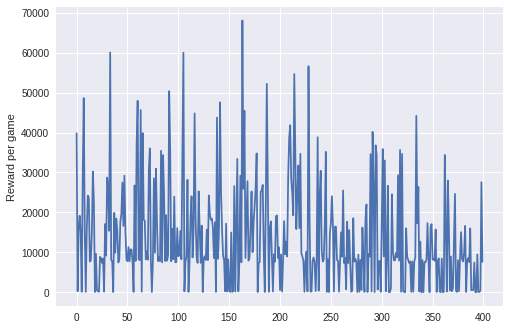

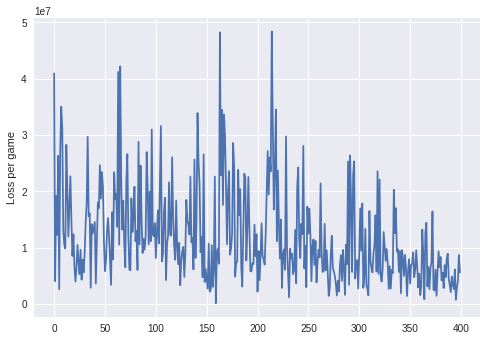

In [ ]:
plt.plot(hist0_75)
plt.ylabel('Reward per game')
plt.show()

plt.plot(loss0_75)
plt.ylabel('Loss per game')
plt.show()

### Results
Sadly, we were not able to correct the convergence of the model. But we can see that with a higher Batch Size the model takes less episodes to start the convergence, however an episode takes longer to train as the computation is more expensive.

## Batch size 1 and 15000 episodes 

As we were not able to fix the convergence of model, we asked ourself, if we train more episodes, the rewards will converged to a small number.
In this model, we changed the decreasing epsilon rate as following: In the first 5000 episode, the epsilon rate decreases as in the preceding models. After that, the epsilon rate remains 5%, as defined in the constant "min_epsilon".

In [ ]:
# parameters
max_epsilon = .4  # exploration
min_epsilon = 0.05
num_actions = 7  # [0, 1, 2, 3, 4, 5, 6]
max_memory = 500 # Maximum number of experiences we are storing
hidden_size = 100 # Size of the hidden layers
batch_size = 1 # Number of experiences we use for training per batch
grid_size = 7 # Size of the playing field

In [ ]:
# Define environment/game
env = gym.make('Drop7-v1')

# Initialize experience replay object
exp_replay = ExperienceReplay(max_memory=max_memory)

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [ ]:
def train(model,epochs, verbose = 1):
    # Train
    #Reseting the win counter
    # We want to keep track of the progress of the AI over time, so we save its win count history
    win_hist = []
    loss_hist = []

    
    #Epochs is the number of games we play
    for e in range(epochs):
        #decreasing epsilon rate, if we are in the first 5000 episodes
        if (e <= 5000):
          progress = e / 5000
          epsilon_diff = max_epsilon - min_epsilon
          epsilon = max_epsilon - (epsilon_diff * progress)
        else:
          epsilon = min_epsilon
        loss = 0.
        win_cnt = 0
        #Resetting the game
        raw_input = env.reset()
        game_over = False
        # get initial input
        input_t = prepare_input(raw_input)
        
        while not game_over:
            #The learner is acting on the last observed game screen
            #input_t is a vector containing representing the game screen
            input_tm1 = input_t
            
            """
            We want to avoid that the learner settles on a local minimum.
            Imagine you are eating eating in an exotic restaurant. After some experimentation you find 
            that Penang Curry with fried Tempeh tastes well. From this day on, you are settled, and the only Asian 
            food you are eating is Penang Curry. How can your friends convince you that there is better Asian food?
            It's simple: Sometimes, they just don't let you choose but order something random from the menu.
            Maybe you'll like it.
            The chance that your friends order for you is epsilon
            """
            if np.random.rand() <= epsilon:
                #Eat something random from the menu
                action = np.random.randint(0, num_actions)
            else:
                #Choose yourself
                #q contains the expected rewards for the actions
                q = model.predict(input_tm1)
                #We pick the action with the highest expected reward
                action = np.argmax(q[0])

            # apply action, get rewards and new state
            raw_input, reward, game_over, something = env.step(action)
            input_t = prepare_input(raw_input)
            #sum the rewards
            win_cnt += reward        
            
            
            """
            The experiences < s, a, r, s’ > we make during gameplay are our training data.
            Here we first save the last experience, and then load a batch of experiences to train our model
            """
            
            # store experience
            exp_replay.remember([input_tm1, action, reward, input_t], game_over) 
            
            # Load batch of experiences
            inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)
  
            # train model on experiences
            batch_loss = model.train_on_batch(inputs, targets)
            
            loss += batch_loss
        if (verbose > 0 and e % 50 == 0):
            print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win count {}".format(e,epochs, loss, win_cnt))
            print(datetime.datetime.now())
        win_hist.append(win_cnt)
        loss_hist.append(loss)
    return win_hist, loss_hist

In [ ]:
#Define model
model = baseline_model(grid_size,num_actions,hidden_size)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_71 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_72 (Dense)             (None, 7)                 707       
Total params: 15,907
Trainable params: 15,907
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epoch = 15000 # Number of games played in training, I found the model needs about 4,000 games till it plays well
# Train the model
# For simplicity of the noteb
hist2, loss2 = train(model, epoch, verbose=1)
print("Training done")

Epoch 000/15000 | Loss 7080854.5873 | Win count 26853.0
2018-12-30 22:49:02.028258
Epoch 050/15000 | Loss 273209.1224 | Win count 8144.0
2018-12-30 22:49:35.731267
Epoch 100/15000 | Loss 20948412.0261 | Win count 34043.0
2018-12-30 22:50:07.262276
Epoch 150/15000 | Loss 13518750.9025 | Win count 15847.0
2018-12-30 22:50:47.465919
Epoch 200/15000 | Loss 7656648.5262 | Win count 8209.0
2018-12-30 22:51:23.299094
Epoch 250/15000 | Loss 1191041.2838 | Win count 9724.0
2018-12-30 22:52:00.621256
Epoch 300/15000 | Loss 54874603.4878 | Win count 25902.0
2018-12-30 22:52:38.718046
Epoch 350/15000 | Loss 6632115.4528 | Win count 7683.0
2018-12-30 22:53:14.392896
Epoch 400/15000 | Loss 21154448.4406 | Win count 8018.0
2018-12-30 22:53:52.279633
Epoch 450/15000 | Loss 12957706.3430 | Win count 7795.0
2018-12-30 22:54:29.263358
Epoch 500/15000 | Loss 360082.0193 | Win count 116.0
2018-12-30 22:55:11.052221
Epoch 550/15000 | Loss 13677572.5680 | Win count 19192.0
2018-12-30 22:55:46.355429
Epoch 60

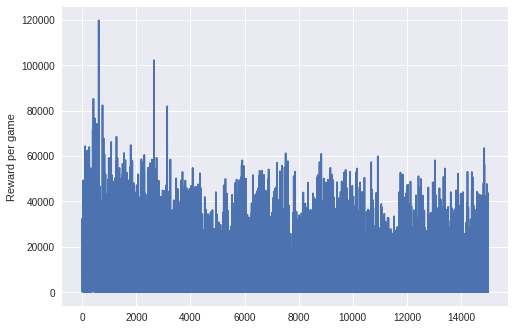

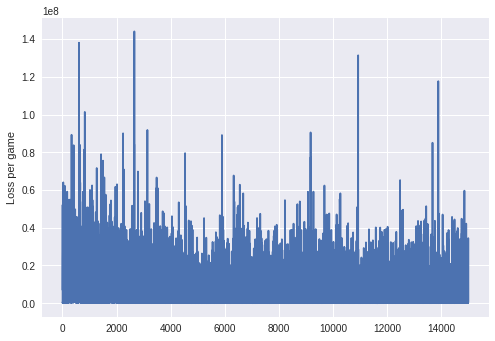

In [ ]:
plt.plot(hist2)
plt.ylabel('Reward per game')
plt.show()

plt.plot(loss2)
plt.ylabel('Loss per game')
plt.show()

##Low epsilon

This model uses low epsilon parameters, so we lowered the chance for the model to find new connections. The model starts with epsilon = 10% and finishes with epsilon = 5%.

In [ ]:
# parameters
max_epsilon = .1  # exploration
min_epsilon = 0.05
num_actions = 7  # [0, 1, 2, 3, 4, 5, 6]
max_memory = 500 # Maximum number of experiences we are storing
hidden_size = 100 # Size of the hidden layers
batch_size = 1 # Number of experiences we use for training per batch
grid_size = 7 # Size of the playing field

In [ ]:
# Define environment/game
env = gym.make('Drop7-v1')

# Initialize experience replay object
exp_replay = ExperienceReplay(max_memory=max_memory)

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [ ]:
#Define model
model = baseline_model(grid_size,num_actions,hidden_size)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 707       
Total params: 15,907
Trainable params: 15,907
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epoch = 2000 # Number of games played in training, I found the model needs about 4,000 games till it plays well
# Train the model
# For simplicity of the noteb
hist3, loss3 = train(model, epoch, verbose=1)
print("Training done")

Epoch 000/2000 | Loss 9201868.7727 | Win count 11608.0
2018-12-31 12:12:10.377124
Epoch 050/2000 | Loss 47045.6422 | Win count 154.0
2018-12-31 12:12:32.863932
Epoch 100/2000 | Loss 1226505.8791 | Win count 15441.0
2018-12-31 12:12:53.302047
Epoch 150/2000 | Loss 32947474.5473 | Win count 42115.0
2018-12-31 12:13:19.379563
Epoch 200/2000 | Loss 273595.1833 | Win count 232.0
2018-12-31 12:13:45.686064
Epoch 250/2000 | Loss 20063411.8719 | Win count 8728.0
2018-12-31 12:14:09.417070
Epoch 300/2000 | Loss 9797842.4746 | Win count 16146.0
2018-12-31 12:14:40.411690
Epoch 350/2000 | Loss 5328035.1304 | Win count 24786.0
2018-12-31 12:15:08.042012
Epoch 400/2000 | Loss 103815.6418 | Win count 91.0
2018-12-31 12:15:30.606687
Epoch 450/2000 | Loss 13522853.4306 | Win count 7478.0
2018-12-31 12:15:53.770644
Epoch 500/2000 | Loss 223454.3781 | Win count 1390.0
2018-12-31 12:16:19.230570
Epoch 550/2000 | Loss 4469486.2323 | Win count 8658.0
2018-12-31 12:16:40.452503
Epoch 600/2000 | Loss 1172564

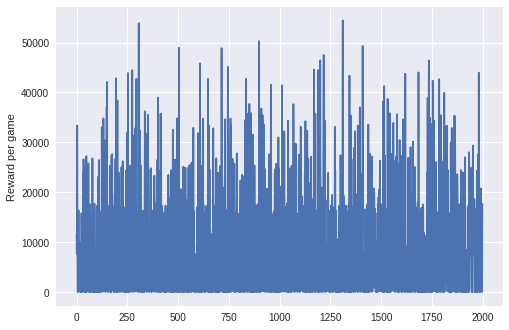

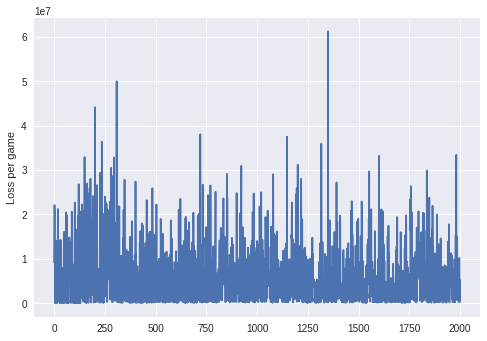

In [ ]:
plt.plot(hist3)
plt.ylabel('Reward per game')
plt.show()

plt.plot(loss3)
plt.ylabel('Loss per game')
plt.show()

### Results
We can see that the model is not converging as it learns a lot slower. So it would take more episodes to learn as much as with a higher epsilon rate.

##Large epsilon

In the preceding model, we saw that decreasing the epsilon rate will slow down the learning. So we tested the opposite, using a start-epsilon rate of 80% and an end-epsilon rate of 5%.

In [ ]:
# parameters
max_epsilon = .8  # exploration
min_epsilon = 0.05
num_actions = 7  # [0, 1, 2, 3, 4, 5, 6]
max_memory = 500 # Maximum number of experiences we are storing
hidden_size = 100 # Size of the hidden layers
batch_size = 1 # Number of experiences we use for training per batch
grid_size = 7 # Size of the playing field

In [ ]:
# Define environment/game
env = gym.make('Drop7-v1')

# Initialize experience replay object
exp_replay = ExperienceReplay(max_memory=max_memory)

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [ ]:
#Define model
model = baseline_model(grid_size,num_actions,hidden_size)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 707       
Total params: 15,907
Trainable params: 15,907
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epoch = 2000 # Number of games played in training, I found the model needs about 4,000 games till it plays well
# Train the model
# For simplicity of the noteb
hist4, loss4 = train(model, epoch, verbose=1)
print("Training done")

Epoch 000/2000 | Loss 24639109.5317 | Win count 28283.0
2018-12-31 12:32:34.074468
Epoch 050/2000 | Loss 13027416.4686 | Win count 28211.0
2018-12-31 12:33:24.853508
Epoch 100/2000 | Loss 45268267.3768 | Win count 47058.0
2018-12-31 12:34:14.944488
Epoch 150/2000 | Loss 22515400.0481 | Win count 42057.0
2018-12-31 12:35:01.556916
Epoch 200/2000 | Loss 21308857.7266 | Win count 41316.0
2018-12-31 12:35:46.173840
Epoch 250/2000 | Loss 4554412.1435 | Win count 16632.0
2018-12-31 12:36:33.662212
Epoch 300/2000 | Loss 4039017.8475 | Win count 15764.0
2018-12-31 12:37:22.063539
Epoch 350/2000 | Loss 40829495.0173 | Win count 47145.0
2018-12-31 12:38:03.082395
Epoch 400/2000 | Loss 21397139.9020 | Win count 45914.0
2018-12-31 12:38:44.827888
Epoch 450/2000 | Loss 58583548.3305 | Win count 18597.0
2018-12-31 12:39:29.972514
Epoch 500/2000 | Loss 18914981.8510 | Win count 44904.0
2018-12-31 12:40:07.510730
Epoch 550/2000 | Loss 5990671.4998 | Win count 8388.0
2018-12-31 12:40:47.650345
Epoch 60

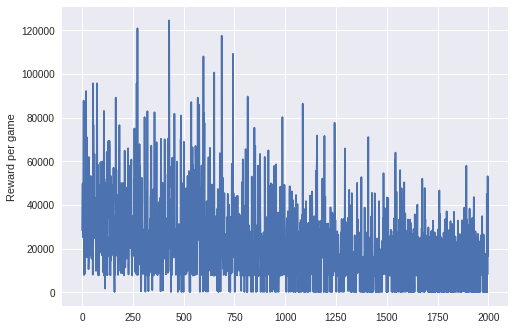

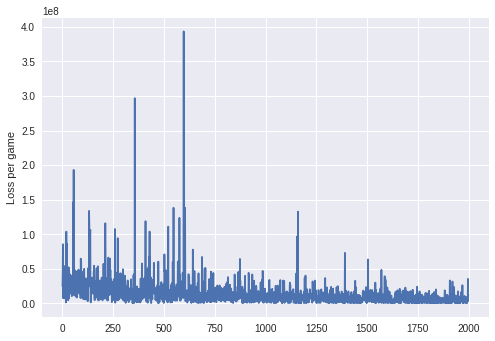

In [ ]:
plt.plot(hist4)
plt.ylabel('Reward per game')
plt.show()

plt.plot(loss4)
plt.ylabel('Loss per game')
plt.show()

### Results
As expected, the model learns a lot faster. We can also see, that in the beginning some quite high rewards are achieved, due to the high epsilon rate. 
In the beginning of the training, rewards lower than 10'000 are quite rare. The model really learns how to achieve low rewards more often, as the training continues.